## [Intro]




In [1]:
### Importation de modules
import requests
import psycopg2
import lxml.html
from lxml import etree
from importlib import reload
import sqlite3 as sql

import pandas as pd
from importlib import reload
import seaborn as sns
from matplotlib import pyplot as plt
from itables import init_notebook_mode, show

In [2]:
import urllib3
### Avoid disturbing messages while scraping
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [3]:
import settings as st

In [ ]:
### POur ne pas demander le password — ou variable d'environnement améliorer
# https://www.delftstack.com/howto/python/import-python-file-from-path/#import-a-module-with-a-full-file-path-in-python-35from importlib.machinery import SourceFileLoader

MODULE_PATH = "c:\\Users\\Rexjohn\\Folder-1\\addmodule.py"
MODULE_NAME = "addmodule"

modulevar = SourceFileLoader(MODULE_NAME, MODULE_PATH).load_module()

modulevar.printingstatement()


## PostgreSQL

## Documentation

* https://www.psycopg.org/docs/usage.html
* https://towardsdatascience.com/python-and-postgresql-how-to-access-a-postgresql-database-like-a-data-scientist-b5a9c5a0ea43
  * noter toutefois que la connection directe avec psychopg2 et pandas ne marche plus
  
__NB__ 
* soit on passe par du SQL pur, et alors on peut utiliser _psycopg2_ comme on utilise sqlite3
* soit on utilise Pandas, mais là il faut un objet SQLAlchemy pour accéder à la base de données  
  
  
  

In [3]:
conn = psycopg2.connect(host="localhost", port = 5432, database="espace_intellectuel", 
                        user="postgres", password=st.dbw)

In [4]:
conn

<connection object at 0x7f101c47ca40; dsn: 'user=postgres password=xxx dbname=espace_intellectuel host=localhost port=5432', closed: 0>

In [5]:
def sql_explore(q):
    errors_list = []
    elem = []
    with conn.cursor() as curs:
        try:   
            ### Décommenter pour nouvelle exécution
            curs.execute(q)
            elem = curs.fetchall()
            conn.commit()
        except Exception as e:
            errors_list.append([i[2], e])
            print(e)
    return [elem, errors_list]        

In [6]:
q1 = """
SELECT COUNT(*), min(ts_creation), max(ts_creation)
FROM astronomers.mathshistory;
"""

In [8]:
result = sql_explore(q1)
print(f'Lines count: {len(result[0])}, errors count: {len(result[1])}, \nFirst lines: {result[0][:5]}')

Lines count: 1, errors count: 0, 
First lines: [(3010, datetime.datetime(2023, 4, 10, 8, 12, 17, 768436), datetime.datetime(2023, 4, 10, 8, 21, 16, 982924))]


In [38]:
q2 = """
SELECT pk_mathshistory, "name", dates, url FROM astronomers.mathshistory WHERE xml_is_well_formed(page_html_txt) IS FALSE ;
"""

In [16]:
### Muliple cards per URL ?
# No one, empty set
q = """
select pk_mathshistory, dates, "name", url , page_html
from astronomers.mathshistory m 
where biography  like '%Summary%'
order by length(biography)
limit 100;
"""

In [17]:
result = sql_explore(q)
print(f'Lines count: {len(result[0])}, errors count: {len(result[1])}, \nFirst lines: {result[0][:5]}')

Lines count: 23, errors count: 0, 
First lines: [(36, '1256-1321', 'Ibn al-Banna', 'https://mathshistory.st-andrews.ac.uk/Biographies/Al-Banna/', '<root><div class="row">\n  <div class="col-md-12">\n    <h1>al-Marrakushi ibn Al-Banna</h1>\n  </div>\n</div>\n\n\n<div class="row">\n  <div class="col-md-8">\n    <h3>Quick Info</h3>\n\n    \n    <dt>Born</dt>\n    <dd>\n      29 December 1256 <br/>  <a href="../../Map/#Marrakesh" target="_blank"> Marrakesh, Morocco </a> \n    </dd>\n     \n    <dt>Died</dt>\n    <dd>\n      13 July 1321 <br/> Marrakesh, Morocco\n    </dd>\n     \n    <hr/>\n    <dt>Summary</dt>\n    <dd><span class="markup"><strong>Ibn al-Banna</strong> was an Islamic mathematician who wrote a large number of works including an introduction to Euclid\'s <em>Elements</em>, an algebra text and various works on astronomy.</span></dd>\n    \n  </div>\n\n   \n  <div class="col-md-4 biography-thumbnail-container">\n    \n    <a href="pictdisplay/" target="_blank">\n      \n     

In [19]:
### Muliple cards per name ?
## Result:
# Lines count: 4, errors count: 0, 
# First lines: [('Gustav von Escherich', [894, 895]), ('John Wilson', [875, 396]), ('Lloyd Williams', [1537, 2536]), ('William Thomson', [700, 992])]
# Deleted one line: https://mathshistory.st-andrews.ac.uk/Biographies/Esterich/ — see below

q4 = """
select "name", array_agg(pk_mathshistory) 
from espace_intellectuel.astronomers.mathshistory m
group by "name" 
having count(*) > 1;
"""

In [22]:
qu = """with tw1 as (
SELECT pk_mathshistory, name, substr(dates, 1, 4)::INTEGER birth_year,
array_to_string(xpath('//div[./h3/text()="Biography"]//a[contains(text(), "THIS LINK")]/@href[contains(., "ocieties")]', page_html), ',') as links
FROM astronomers.mathshistory)
select *
from tw1
where length(links) > 5;"""

In [23]:
with conn.cursor() as curs:
    try:   
        ### Décommenter pour nouvelle exécution
        curs.execute(qu)
        conn.commit()
    except Exception as e:
        print(e)

In [24]:
q = """
select * from astronomers.mathshistory m where length(page_html::text) = 0;
"""

In [25]:
result = sql_explore(q)
print(f'Lines count: {len(result[0])}, errors count: {len(result[1])}, \nFirst lines: {result[0][:5]}')

Lines count: 0, errors count: 0, 
First lines: []


In [22]:
q = """
SELECT pk_mathshistory, name, substr(dates, 1, 4)::INTEGER birth_year,
array_to_string(xpath('//dt[text()="Summary"]/following-sibling::dd/descendant-or-self::*/text()', page_html), ' ') as summary
FROM astronomers.mathshistory
limit 10;
"""

In [23]:
result = sql_explore(q)
print(f'Lines count: {len(result[0])}, errors count: {len(result[1])}, \nFirst lines: {result[0][:5]}')

Lines count: 10, errors count: 0, 
First lines: [(135, 'Johannes Kepler', 1571, 'Johannes Kepler  was a German mathematician and astronomer who discovered that the Earth and planets travel about the sun in elliptical orbits. He gave three fundamental laws of planetary motion. He also did important work in optics and geometry.'), (21, 'Michael Scot', 1175, 'Michael Scot   ( or  Scotus )  helped in the transmission of Islamic mathematics from Spain to the rest of Europe.'), (22, 'Li Zhi', 1192, 'Li Zhi  was a Chinese mathematician who described methods for solving equations.'), (23, 'John Sacrobosco', 1195, 'John of Holywood  or  Johannes de Sacrobosco  was an English scholar who wrote an important text on astronomy and promoted Arabic methods of arithmetic and algebra.'), (24, 'Albertus', 1200, "Albert   ( or  Albertus Magnus )  was a German Dominican who wrote a commentary on Euclid's  Elements . He was made a Saint in  1931  and, in  1941 , was made patron of natural scientists.")]


In [25]:
q1 = """
UPDATE astronomers.mathshistory SET summary = array_to_string(xpath('//dt[text()="Summary"]/following-sibling::dd/descendant-or-self::*/text()', page_html), ' ');
"""

In [26]:
errors_list = []
elem = []
with conn.cursor() as curs:
    try:   
        ### Décommenter pour nouvelle exécution
        curs.execute(q1)
        ## conn.commit()
    except Exception as e:
        print(e)
conn.commit()        

In [38]:
q = """
select length(summary) l_summary, summary, name, dates, pk_mathshistory from astronomers.mathshistory ;
"""

In [39]:
result = sql_explore(q)
print(f'Lines count: {len(result[0])}, errors count: {len(result[1])}, \nFirst lines: {result[0][:5]}')

Lines count: 3010, errors count: 0, 
First lines: [(114, 'Michael Scot   ( or  Scotus )  helped in the transmission of Islamic mathematics from Spain to the rest of Europe.', 'Michael Scot', '1175-1235', 21), (164, 'John of Holywood  or  Johannes de Sacrobosco  was an English scholar who wrote an important text on astronomy and promoted Arabic methods of arithmetic and algebra.', 'John Sacrobosco', '1195-1256', 23), (188, "Albert   ( or  Albertus Magnus )  was a German Dominican who wrote a commentary on Euclid's  Elements . He was made a Saint in  1931  and, in  1941 , was made patron of natural scientists.", 'Albertus', '1200-1280', 24), (193, 'Nasir al-Tusi  was an Islamic astronomer and mathematician who joined the Mongols who conquered Baghdad. He made important contributions to astronomy and wrote many commentaries on Greek texts.', 'Nasir al-Din al-Tusi', '1201-1274', 25), (141, 'Qin Jiushao  was a Chinese mathematician who wrote an important study  Shushu Jiuzang  on equations,

In [50]:
result[0][100:102]

[(237,
  "John Napier  was a Scottish scholar who is best known for his invention of logarithms, but other mathematical contributions include a mnemonic for formulas used in solving spherical triangles and two formulas known as Napier's analogies.",
  'John Napier',
  '1550-1617',
  116),
 (107,
  "Michael Mästlin  was a German astronomer who was Kepler's teacher and who publicised the Copernican system.",
  'Michael Mästlin',
  '1550-1631',
  117)]

## Exploration of summaries' sizes

In [51]:
df = pd.DataFrame(result[0])
df.columns = ['txt_len','summary', 'name', 'dates', 'pk']

In [52]:
df.head()

,txt_len,summary,name,dates,pk
0,114,Michael Scot ( or Scotus ) helped in the t...,Michael Scot,1175-1235,21
1,164,John of Holywood or Johannes de Sacrobosco ...,John Sacrobosco,1195-1256,23
2,188,Albert ( or Albertus Magnus ) was a German...,Albertus,1200-1280,24
3,193,Nasir al-Tusi was an Islamic astronomer and m...,Nasir al-Din al-Tusi,1201-1274,25
4,141,Qin Jiushao was a Chinese mathematician who w...,Qin Jiushao,1202-1261,26


In [53]:
tl = df['txt_len']
tl.describe()

count    3010.000000
mean      137.818937
std        58.516013
min         0.000000
25%        99.000000
50%       123.000000
75%       160.000000
max       470.000000
Name: txt_len, dtype: float64

(0.0, 470.0)

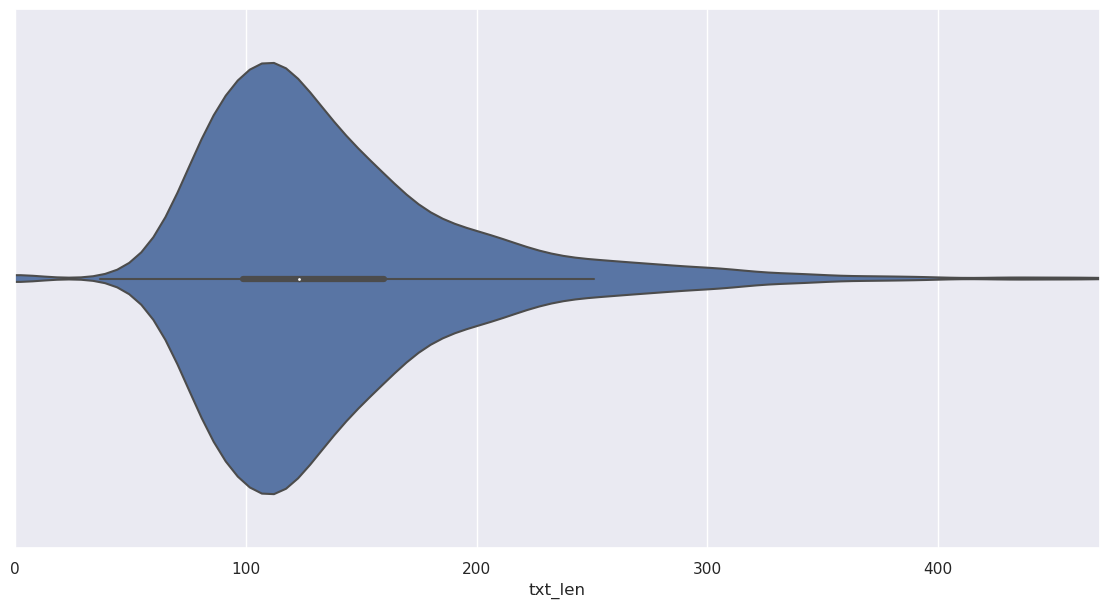

In [55]:
### Violinplot : rend visible la différente densité de la distribution
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

a = tl
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


In [62]:
### https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df[df['txt_len']>0].sort_values(by='txt_len'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [60]:
f = 'data/biographies.csv'

In [61]:
df[df['txt_len']>0].sort_values(by='txt_len').to_csv(f)